In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

## Modelisation

In [19]:
df = pd.read_csv("df_go_modelisation.csv")
df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,...,long,senc,catv,obs,obsm,choc,manv,motor,heure,minute
0,1,1,2,1,2008.0,5,2,8,-1,-1,...,4.725720,1,2,0,2,1,9,1,16,15
1,1,1,1,1,1948.0,5,1,8,-1,-1,...,4.725720,1,7,0,2,2,1,1,16,15
2,1,1,2,1,1988.0,9,1,0,-1,0,...,6.346200,2,7,0,2,8,15,1,8,34
3,1,1,1,1,1970.0,4,1,0,-1,0,...,6.346200,2,10,0,2,1,1,1,8,34
4,1,1,1,1,2002.0,0,1,0,-1,-1,...,-2.760439,2,7,0,2,1,2,1,17,15


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.25)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Séparation des labels et targets : (347733, 43) (115912, 43) (347733,) (115912,)


In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Choix des modèles

Le choix s'est porté sur les modèles de logistic Regression, AdaBoost et Lgbm, puisqu'ils ne souffrent pas de sur-apprentissage ou de sous-apprentissage tout en offrant de bonnes performances.

### Logistic Regression

#### Choisir la meilleure sélection de variables

In [22]:
# /!\ 

best_accuracy_lr = 0
best_k_lr = 0

for k in range(1, X_train_scaled.shape[1] + 1):
    select_k_best_lr = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best_lr = select_k_best_lr.fit_transform(X_train_scaled, y_train)
    X_test_k_best_lr = select_k_best_lr.transform(X_test_scaled)
    
    model_k_lr = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_k_lr.fit(X_train_k_best_lr, y_train)
    
    y_pred_k_lr = model_k_lr.predict(X_test_k_best_lr)
    accuracy_k_lr = accuracy_score(y_test, y_pred_k_lr)
    
    if accuracy_k_lr > best_accuracy_lr:
        best_accuracy_lr = accuracy_k_lr
        best_k_lr = k

print("Best number of features:", best_k_lr)
print("Best accuracy:", best_accuracy_lr)

Best number of features: 31
Best accuracy: 0.7185537304161778


#### Application de la meilleure sélection de features

In [38]:
selector = SelectKBest(f_classif, k=31)

X_train_kb = selector.fit_transform(X_train_scaled, y_train)
X_test_kb = selector.transform(X_test_scaled)

print(X_train_kb.shape, X_test_kb.shape)

(347733, 31) (115912, 31)


In [39]:
hyper_p_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
#    'penalty': ['l1', 'l2'],              
    'solver': ['liblinear', 'saga']       
}

gs_lr = GridSearchCV(estimator = LogisticRegression(max_iter = 1000),
                           param_grid = hyper_p_lr,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 1,
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_lr.fit(X_train_kb, y_train)

best_hp_lr = gs_lr.best_params_
best_score_lr = gs_lr.best_score_

print("Meilleurs paramètres trouvés:", best_hp_lr)
print("Meilleur score de validation croisée:", best_score_lr)

best_model = gs_lr.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres trouvés: {'C': 0.001, 'solver': 'saga'}
Meilleur score de validation croisée: 0.7156323912513672


In [41]:
y_pred_lr = best_model.predict(X_test_kb)

report_lr = classification_report(y_test, y_pred_lr)
  
cv_results = gs_lr.cv_results_

print(report_lr)
print(cv_results)

              precision    recall  f1-score   support

           1       0.67      0.64      0.66     48274
           2       0.75      0.77      0.76     67638

    accuracy                           0.72    115912
   macro avg       0.71      0.71      0.71    115912
weighted avg       0.72      0.72      0.72    115912

{'mean_fit_time': array([4.39460235, 5.26161261, 5.37326546, 5.33512616, 5.42046509,
       5.49882579, 4.86524115, 5.17908802, 4.87138686, 5.61100855,
       4.44407811, 4.17718554]), 'std_fit_time': array([0.60740318, 0.21494303, 0.98390481, 0.33915874, 1.28374734,
       0.29501487, 0.710518  , 0.40763468, 0.79711926, 0.19183179,
       0.12466091, 0.43272495]), 'mean_score_time': array([0.01589518, 0.0205966 , 0.02098088, 0.01904364, 0.01735058,
       0.01699867, 0.01581011, 0.01665406, 0.01691537, 0.0160563 ,
       0.01296706, 0.00590024]), 'std_score_time': array([0.0031768 , 0.00226448, 0.00266668, 0.00466337, 0.00296462,
       0.00176463, 0.00312411, 0.0

#### Confusion matrice de logistic regression

Matrice de confusion :
 [[31014 17260]
 [15395 52243]]


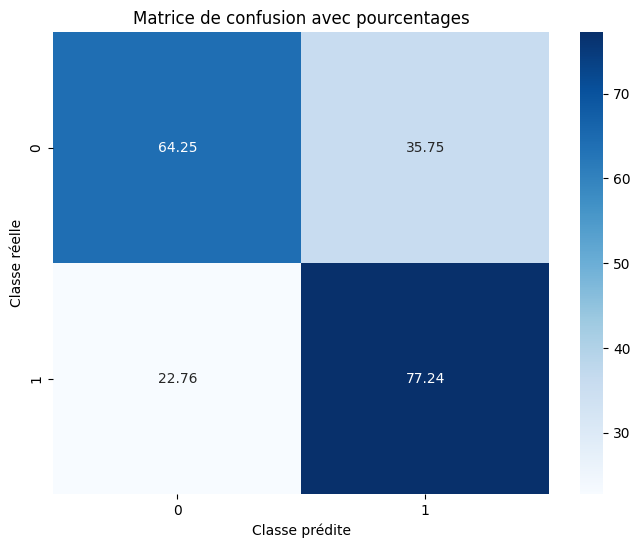

In [42]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Matrice de confusion :\n", cm_lr)

row_sums_lr = cm_lr.sum(axis = 1)
cm_percent_lr = (cm_lr.T / row_sums_lr).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lr, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Adaboost Classifier

In [80]:
hp_ada = {
    'n_estimators': [50, 100, 200, 250],        # Nombre de classificateurs faibles
    'learning_rate': [0.01, 0.1, 0.5],     # Taux d'apprentissage
    'algorithm': ['SAMME', 'SAMME.R']      # Algorithme utilisé; 'SAMME.R' deprecied
}

In [81]:
gs_ada= GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                           param_grid = hp_ada,
                           cv=5,  # Nombre de folds pour la validation croisée
                           verbose=1,
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [82]:
gs_ada.fit(X_train_kb, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [50, 100, 200, 250]},
             verbose=1)

In [83]:
best_hp_ada = gs_ada.best_params_
best_score_ada = gs_ada.best_score_
best_estimator_ada = gs_ada.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_ada)
print("Meilleur score de validation croisée:", best_score_ada)

Meilleurs paramètres trouvés: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 250}
Meilleur score de validation croisée: 0.7895856873299906


In [84]:
y_pred_ada = best_estimator_ada.predict(X_test_kb)

cv_results_ada = gs_ada.cv_results_

#### Matrice de confusion de Adaboost Classifier

Matrice de confusion :
 [[37730 10544]
 [13865 53773]]


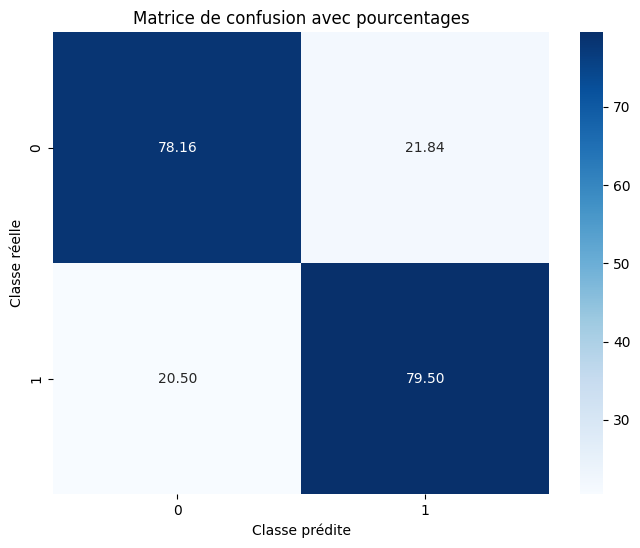

In [85]:
cm_ada = confusion_matrix(y_test, y_pred_ada)
print("Matrice de confusion :\n", cm_ada)

row_sums_ada = cm_ada.sum(axis = 1)
cm_percent_ada = (cm_ada.T / row_sums_ada).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### LGBMClassifier

In [86]:
hp_lgbm = {
    'learning_rate': [0.01, 0.1, 1.0],                # Taux d'apprentissage
    'n_estimators': [50, 100],                        # Nombre d'estimateurs
    'num_leaves': [20, 30, 40],                       # Nombre maximum de feuilles par arbre
    'boosting_type': ['gbdt', 'dart', 'goss'],        # Type de boosting
    'subsample': [0.8, 1.0],                          # Sous-échantillonnage des données
    'colsample_bytree': [0.8, 1.0]                   # Fraction de colonnes à utiliser par arbre
}

In [87]:
gs_lgbm = GridSearchCV(estimator=LGBMClassifier(),
                           param_grid= hp_lgbm,
                           cv=5,  # Nombre de folds pour la validation croisée
                           verbose=1,
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [88]:
gs_lgbm.fit(X_train_kb, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162756, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162756, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.011998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [1]:
best_hp_lgbm = gs_lgbm.best_params_
best_score_lgbm = gs_lgbm.best_score_
best_estimator_lgbm = gs_lgbm.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_lgbm)
print("Meilleur score de validation croisée:", best_score_lgbm)

NameError: name 'gs_lgbm' is not defined

In [ ]:
y_pred_lgbm = best_estimator_lgbm.predict(X_test_kb)

cv_results_lgbm = gs_lgbm.cv_results_

#### Matrice de confusion de lgbm classifier

In [ ]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Matrice de confusion :\n", cm_lgbm)

row_sums_lgbm = cm_lgbm.sum(axis = 1)
cm_percent_lgbm = (cm_lgbm.T / row_sums_lgbm).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lgbm, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()